In [24]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/ModelsResults')
sys.path.insert(0, '/home/jtorrenc/mvesc/Features')

from mvesc_utility_functions import *
from estimate_prediction_model import build_outcomes_plus_features,temporal_cohort_test_split,impute_missing_values
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
import yaml
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def scale_features(train, val, test, strategy):
    """                                                                         
    Scales features based on the training values with the given strategy   
    Modified here to also return the scaler
                                                                                
    :param pd.DataFrame train:                                                  
    :param pd.DataFrame val:                                                    
    :param pd.DataFrame test:                                                   
    :param str strategy:                                                        
    :returns: scaled training, val, and test sets                               
    :rtype: pd.DataFrame, pd.DataFrame, pd.DataFrame                            
    """
    zero_variance_columns = [x for x in train.columns if len(train[x].unique()) == 1]
    train.drop(zero_variance_columns, axis=1, inplace=True)
    val.drop(zero_variance_columns, axis=1, inplace=True)
    test.drop(zero_variance_columns, axis=1, inplace=True)

    if (strategy == 'none'):
        return train, val, test

    elif(strategy == 'standard' or strategy == 'robust'):
        non_binary_columns = [x for x in train.columns if  len(train[x].unique())>2]
        if (len(non_binary_columns) > 0):
            scaler = StandardScaler() if strategy == 'standard' \
                     else RobustScaler()
            train_non_binary = train[non_binary_columns]
            val_non_binary = val[non_binary_columns]
            test_non_binary = test[non_binary_columns]
            scaler.fit(train_non_binary)
            train_non_binary = pd.DataFrame(scaler.transform(train_non_binary),
                columns = non_binary_columns, index = train.index)
            val_non_binary = pd.DataFrame(scaler.transform(val_non_binary),
                columns = non_binary_columns, index = val.index)
            test_non_binary = pd.DataFrame(scaler.transform(test_non_binary),
                columns = non_binary_columns, index = test.index)
            train_scaled = train.drop(non_binary_columns, axis=1)
            val_scaled = val.drop(non_binary_columns, axis=1)
            test_scaled = test.drop(non_binary_columns, axis=1)
            train_scaled = train_scaled.merge(train_non_binary,
                left_index=True, right_index=True)
            val_scaled = val_scaled.merge(val_non_binary,
                left_index=True, right_index=True)
            test_scaled = test_scaled.merge(test_non_binary,
                left_index=True, right_index=True)
            return train_scaled,val_scaled, test_scaled, scaler
        else:
            return train, val, test, scaler

    else:
        print('unknown feature scaling strategy. try "{}", "{}", or "{}"'\
              .format('standard', 'robust', 'none'))
        return train, val, test

In [60]:
def read_and_preprocess(filename):
    model_name = filename.split('_')[-3]
    with open('/mnt/data/mvesc/Models_Results/pkls/'+filename+'_'+ model_name + '.pkl', "rb" ) as f:
        d = pickle.load(f)
    model_options = d['model_options']
    model = d['estimator']
    columns = d['estimator_features']
    outcome_plus_features = build_outcomes_plus_features(model_options,None)
    outcome_plus_features.dropna(subset=[model_options['outcome_name'],
            model_options['cohort_grade_level_begin']], inplace=True)
    train, val, test = temporal_cohort_test_split(outcome_plus_features,
            model_options['cohort_grade_level_begin'],
            model_options['cohorts_test'],
            model_options['cohorts_val'],
            model_options['cohorts_training'])
    train_X_pre = train.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
    test_X_pre = test.drop([model_options['outcome_name'],
                        model_options['cohort_grade_level_begin']],axis=1)
    val_X_pre = val.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
    train_y = train[model_options['outcome_name']]
    test_y = test[model_options['outcome_name']]
    val_y = val[model_options['outcome_name']]
    train_X, val_X, test_X = impute_missing_values(train_X_pre, val_X_pre, test_X_pre,\
    model_options['missing_impute_strategy'])
    train_X = train_X.filter(columns)
    val_X = val_X.filter(columns)
    test_X = test_X.filter(columns)
    train_X, val_X, test_X, scaler = scale_features(train_X, val_X, test_X,
                                                    model_options['feature_scaling'])
    X = pd.concat([train_X,val_X,test_X])
    X_pre = pd.concat([train_X_pre,val_X_pre,test_X_pre])

    return X, X_pre, scaler, columns, model

In [27]:
def get_feature_scores(filename):
    with postgres_pgconnection_generator() as connection:
        with connection.cursor() as cursor:
            cursor.execute("""select feature,importance from model.feature_scores
                                    where filename = '{}'; """.format(filename))
            temp = cursor.fetchall()
    scores = pd.DataFrame(temp, columns = ['feature','importance'])
    scores.set_index('feature', inplace=True)
    return scores

In [28]:
def split_columns(X, columns):
    binary_features = pd.DataFrame(~X.apply(lambda x: len(x.unique()),axis=0).gt(2), columns = ['binary'])
    cts_columns = [c for c in columns if not binary_features['binary'].loc[c]]
    binary_columns = [c for c in columns if binary_features['binary'].loc[c]]
    return cts_columns, binary_columns

In [29]:
def categorical_feature_dict(all_features_path, binary_columns):
    with open(all_features_path, 'r') as f:
            all_features = yaml.load(f)
    feature_base = itertools.chain.from_iterable([a  for a in all_features.values()])
    feature_base = [y[:-1] if '*' in y else y for y in feature_base]
    binary_base = set()
    for f in feature_base:
        for b in binary_columns:
            if f in b and 'null' not in b:
                base = []
                flag=False
                if 'gr' in b:
                    for a in b.split('_'):
                        if flag:
                            base.append(a)
                            break
                        base.append(a)
                        if a=='gr':
                            flag=True
                    binary_base.add('_'.join(base))
                else:
                    binary_base.add(f)
    binary_base = list(binary_base)
    binary_dict = {}
    for b in binary_base:
        binary_dict[b] = [f for f in binary_columns if b == f[:len(b)]]
    return binary_dict

In [30]:
def plot_binary_features(model, student, binary_dict, train_X):
    X_student = train_X.loc[student]
    for base, features in binary_dict.items():
        X = pd.DataFrame(np.tile(X_student,[len(features),1]).transpose(),index=X_student.index) # reset X matrix
        for i,f in enumerate(features):
            if train_X[f].loc[student]:
                current_val = f[len(base)+1:]
            for g in features:
                X[i].loc[g] = 1 if g == f else 0
        prob = [a[1] for a in model.predict_proba(X.transpose())]
        current_val_ind = [i for i,f in enumerate(features) if current_val in f][0]
        fig, ax = plt.subplots()
        plt.scatter( np.arange(len(features)), prob);
        plt.scatter( current_val_ind , prob[current_val_ind], label=current_val, color = 'red');
        ax.set_xticks( np.arange(len(features)))
        ax.set_xticklabels( [f[len(base)+1:] for f in features], rotation=90 ) ;
        plt.ylim([0,1])
        plt.title('{0} for student {1}'.format(base,student));

In [31]:
def plot_cts_features(model, student, cts_columns, train_X_pre, train_X, scaler):
    X_student = train_X.loc[student]
    n_steps = 100
    for feature in cts_columns:
        X = pd.DataFrame(np.tile(X_student,[n_steps,1]).transpose(),index=X_student.index) # reset X matrix
        current_val = train_X_pre[feature].loc[student]

        if not np.isnan(current_val): # skip null values
            values = np.linspace(min(train_X[feature]), max(train_X[feature]), n_steps)
            for i,v in enumerate(values):
                X[i].loc[feature] = v
            prob = [a[1] for a in model.predict_proba(X.transpose())]
            values_pre = pd.DataFrame(scaler.inverse_transform(X.loc[cts_columns].transpose()).transpose(),
                                index = cts_columns,
                                columns = X.columns)
            values_pre = values_pre.loc[feature]
            plt.figure()
            plt.hold='on'
            plt.vlines(current_val,0,1,label=str(current_val))
            plt.plot(values_pre, prob);
            plt.ylim([0,1])
            plt.xlim([min(values_pre)-1,max(values_pre)+1])
            #plt.legend()
            plt.title('{0} for student {1}'.format(feature,student));

In [50]:
def cts_feature_importance(model, student, cts_columns, train_X_pre, train_X, scaler, shift):
    X_student = train_X.loc[student]
    for feature in cts_columns:
        X = pd.DataFrame(np.tile(X_student,[3,1]).transpose(),index=X_student.index) # reset X matrix
        X[0].loc[feature] = X[1].loc[feature] - shift
        X[2].loc[feature] = X[1].loc[feature] + shift
        prob = [a[1] for a in model.predict_proba(X.transpose())]
        print(feature, min(prob[1]-prob[0],prob[1]-prob[2]))
        #print('shift {0} down: {1:.02}, shift {0} up: {2:.02}'.format(feature, prob[1]-prob[0],prob[1]-prob[2] ))

In [33]:
def plot_features(model_filename, student, all_features_path):
    X, X_pre, scaler, column_order, model = read_and_preprocess(filename)
    cts_columns, binary_columns = split_columns(X, column_order)
    binary_dict = categorical_feature_dict(all_features_path, binary_columns)
    plot_cts_features(model, student, cts_columns, X_pre, X, scaler)
    plot_binary_features(model, student, binary_dict, X)

In [47]:
def get_feature_importances(model_filename, student, all_features_path, shift):
    X, X_pre, scaler, column_order, model = read_and_preprocess(filename)
    cts_columns, binary_columns = split_columns(X, column_order)
    binary_dict = categorical_feature_dict(all_features_path, binary_columns)
    cts_feature_importance(model, student, cts_columns, X_pre, X, scaler, shift)

In [64]:
filename = '08_17_2016_grade_10_param_set_22_logit_jg_123'
student = 38736
all_features_path = '../Features/all_features.yaml'

In [65]:
#get_feature_importances(filename, student, all_features_path, 1)

/home/jgutman/env/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


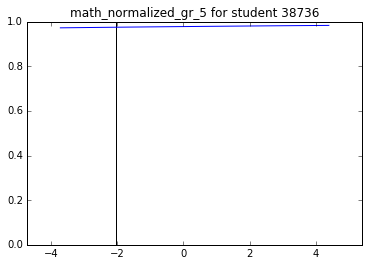

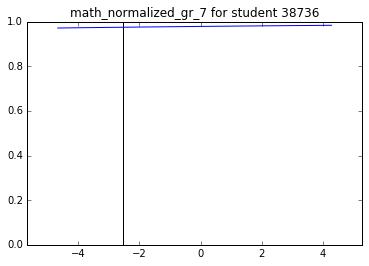

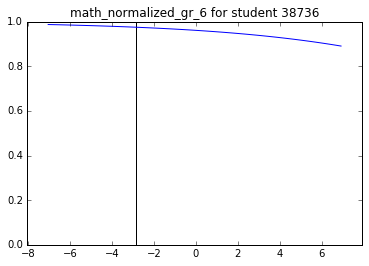

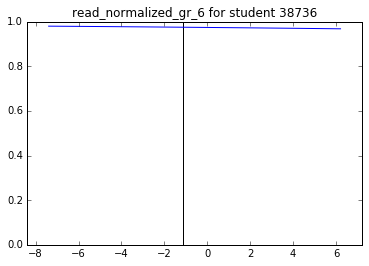

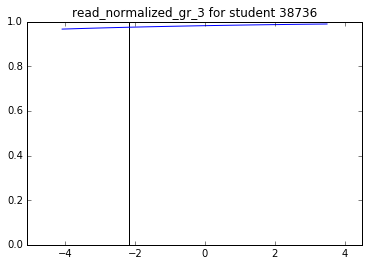

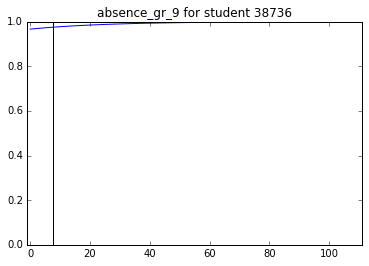

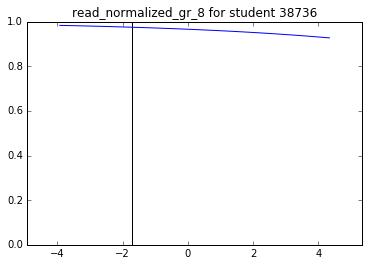

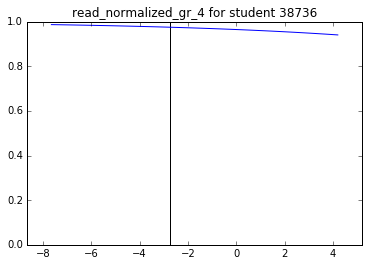

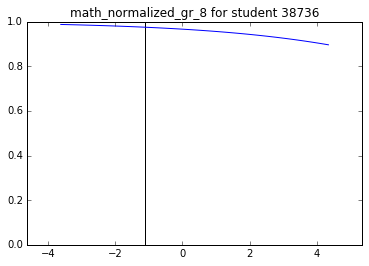

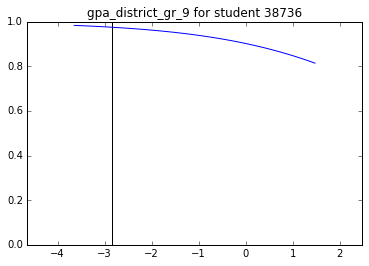

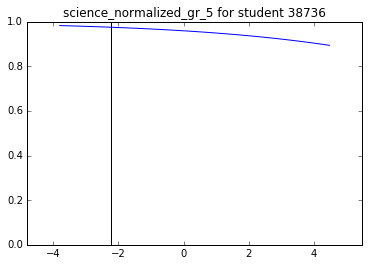

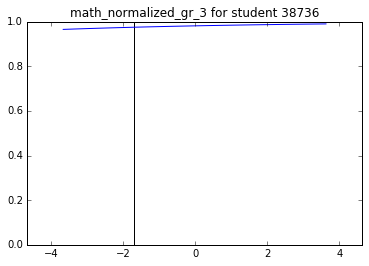

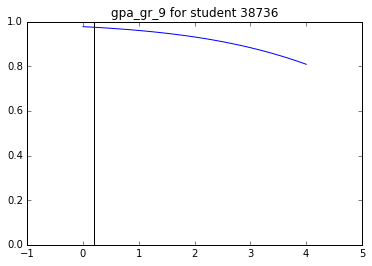

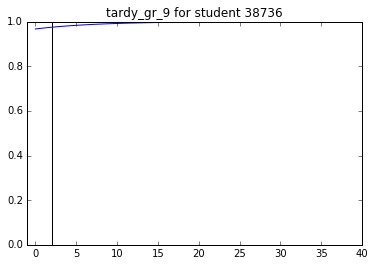

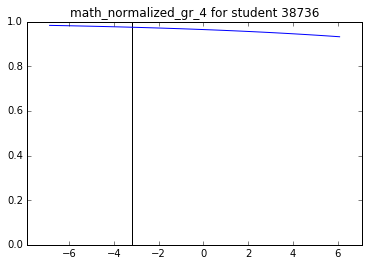

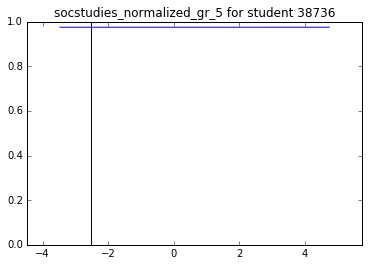

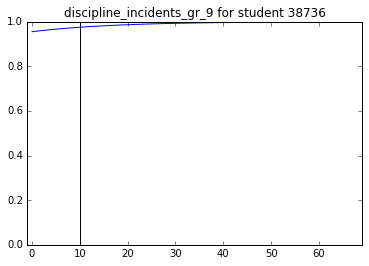

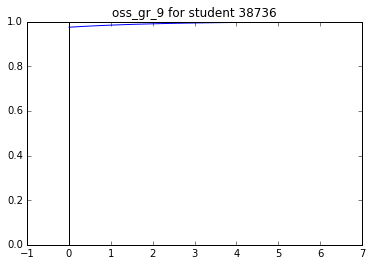

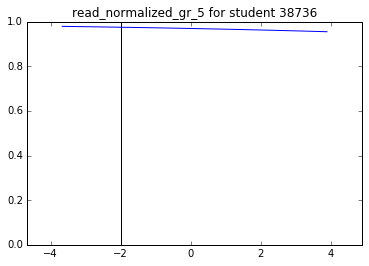

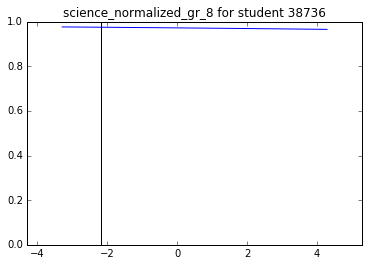

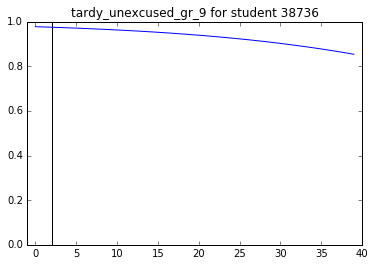

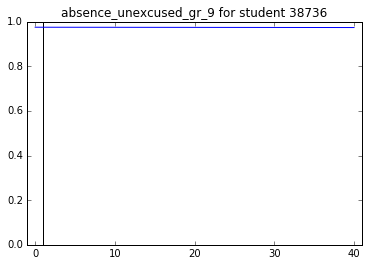

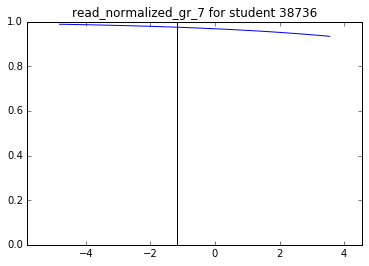

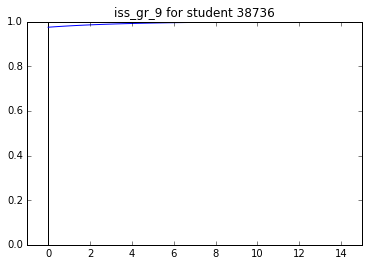

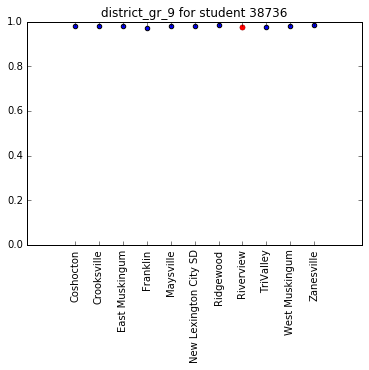

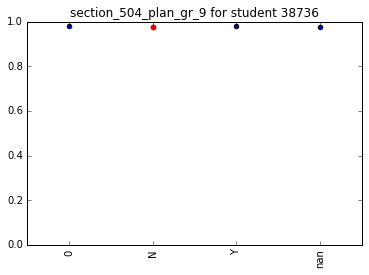

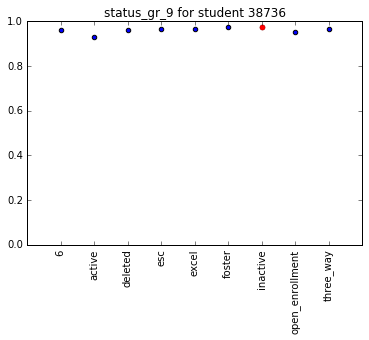

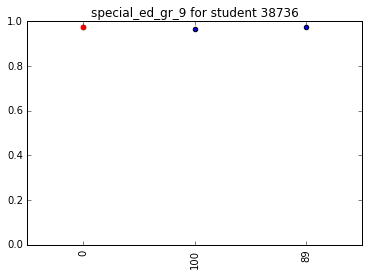

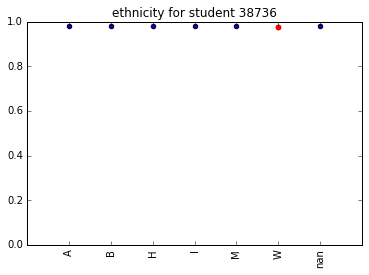

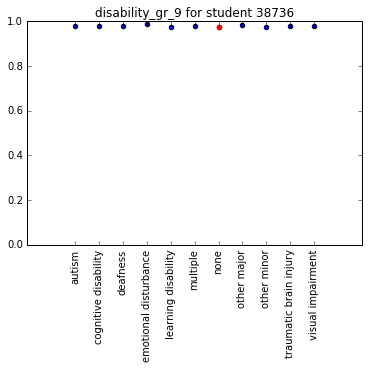

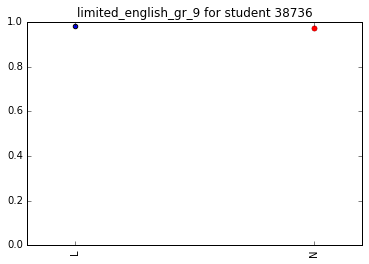

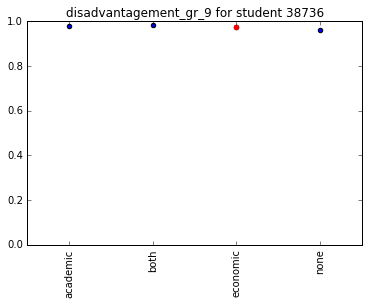

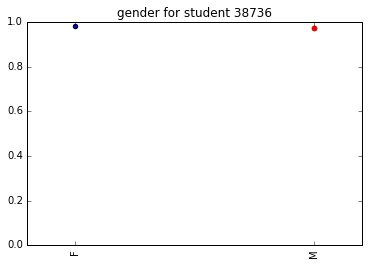

In [66]:
plot_features(filename, student, all_features_path)
